# Using LDA and Jensen-Shannon Distance (JSD) to group similar newspaper articles 


Many researchers have the problem that their data sets or automated set annotations contain articles that are irrelevant to their research question. For many reserarch topics, search requests are difficult to define conceptually and hard, if not impossible, to trace by a simple keyword search alone. Additionally, when building topic-specific corpora using queries, there is always a compromise between the precision and the recall of such search queries. In other words, on one hand, there is a conflict between creating a corpus that contains only relevant texts but not all texts available in the entire collection are relevant. For example, if the goal is to find articles on return migration, researchers have to deal with some ambiguous search terms. The German words "Heimkehr" (returning home) or "Rückkehr" (returning back) lead to many articles that are relevant to the research question, but also to articles that are not relevant (e.g. return from a mountain tour, work, etc.). By using topic models and document similarity measurements, this notebook allows to exclude these articles without combining the the terms "Heimkehr", "Rückkehr", "Rückwanderung", "Rückwanderer" or "Rückkehrer" with other search terms.

The main purpose of this notebook is to consider the context of a search query (in this case the whole content of a newspaper clipping where the keyword appears) to measure the relevance, on the other hand, can make the search less influenced by the researcher's prior knowledge and avoid a too narrow tunnel vision.

#### So how is this working? 

Given a manually annotated collection of articles containing relevant as well as non relevant articles, this program will get the topic distribution of each document using LDA (gensim library). These topic distributions serve as a comparison for other, unseen articles, in order to automatically distinguish between relevant and non-relevant articles. The annotations are used for evaluation and counting the relevance probability for an unseen article. 

For the comparison, the Jensen-Shannon distance method is used to measure the similarity between the topic distribution of an unseen article and the topic distribution of the training corpus. Therefore, the topic distribution of each new article will be compared to the topic distribution of the articles in the trained corpus. Then, for each unseen article, the 10 most similar articles from the training corpus are being extracted. These articles carry the information about the manually assigned relevancy. If 60 precent of the automatically found similar articles were annotated as relevant, the new article will be marked as relevant. Otherwise it will be marked as irrelevant. Using two different datasets (one about cancer and one about return migration), the average score of correct selected articles is between 80 and 90 percent. 

Read more about <a href="https://monkeylearn.com/blog/introduction-to-topic-modeling/" target="_blank">Topic Modeling</a> and the <a href="https://axialcorps.wordpress.com/tag/jensen-shannon-divergence/" target="_blank">Jensen-Shannon distance method</a>.


## Step by step...
* [Preparing a small manually annotated collection](#1-bullet)
* [Installing packages in command line](#2-bullet)
* [Importing packages](#3-bullet)
* [Importing your manually annotated newspaper collection](#4-bullet)
* [Cleaning and tokenizing the text (pre-processing)](#5-bullet)
* [Optional: Reducing your data to nouns, adjectives, verbs, or adverbs](#6-bullet)
* [Having a look at your data](#7-bullet)
* [Removing articles that are too short](#8-bullet)
* [Using the dataset to create a training corpus and test corpus](#9-bullet)
* [Creating topic models using your training corpus](#10-bullet)
* [Finding the dominant topic for each article](#11-bullet)
* [Finding similar articles using the Jensen Shannon function](#12-bullet)
* [Calculating the score of the output](#13-bullet)
* [Using the whole collection](#14-bullet)
* [Cleaning (pre-process) the whole collection](#15-bullet)
* [Optional: Reducing your data to nouns, adjectives, verbs, or adverbs](#16-bullet)
* [Calculating similarities in comparing articles to the training corpus](#17-bullet)
* [Exporting the results to check if the method worked well ](#18-bullet)
* [Exporting the final collection](#19-bullet)



## Preparing a small manually annotated collection <a class="anchor" id="1-bullet"></a>

This program uses a manually annotated dataset on returm migration for the calcuation of the relevanvy-probability and to successfully distinguish between relevant and non-relevant articles. Therefore, a manually annotated collection of 219 articles has been created with and exported from the <a href="https://platform.newseye.eu" target="_blank">NewsEye Platform</a>. This platform allows to create and manage datasets as well as adding annotations to the dataset. This means that 130 articles have been manually annotated as relevant (by assigning the number 3) and 89 articles have been annotated as irrelevant (by assigning the number 0). While creating and annotating the dataset, value was placed on the representativity of the collection (in covering all possible topics and time frames).

The following steps are illustrated using the case study on return migration. The main goal is to separate the relevant from the irrelevant articles and to export the "cleaned" collection as CSV. Thus, the articles I want to keep deal with remigratory processes between 1850 and 1950, while the articles I want to remove deal with all kinds of topics including the word "Heimkehr" (return from the mountain trip, vacation, work, etc.). 

## Installing packages in command line <a class="anchor" id="2-bullet"></a>
 

pip install pandas

pip install spacy

pip install regex

pip install nltk

pip install matplotlib

pip install numpy

pip install seaborn

pip install gensim


## Importing packages <a class="anchor" id="3-bullet"></a>

Before you can get started, you have to install and import some packages. We are using Gensim for the topic modeling and similartiy mesure. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.utils import lemmatize, simple_preprocess
import spacy


import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

import sys
import re, numpy as np, pandas as pd
from pprint import pprint

## Importing the manually annotated newspaper collection <a class="anchor" id="4-bullet"></a>


In [2]:
import csv

In [3]:
df = pd.read_csv('export_remigration_06_06_2020_18_57.csv')

### Having a look at the data

In [4]:
df.head(5)

,id,language,date,newspaper_id,iiif_url,relevancy,text
0,neue_freie_presse_nfp18650323_article_595,de,1865-03-23T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,0,Endesgefertigter litt seit längerer Zeit an Ma...
1,neue_freie_presse_nfp18650301_article_368,de,1865-03-01T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,0,„ „Adepesertister lt seit längerer Seit an Mag...
2,neue_freie_presse_nfp18650308_article_609,de,1865-03-08T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,0,Endesgefertigter litt seit längerer Zeit an Ma...
3,illustrierte_kronen_zeitung_krz19381218_articl...,de,1938-12-18T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,3,Der Leiter der Zweigstelle Wien des Rückwander...
4,innsbrucker_nachrichten_ibn19120525_article_1689,de,1912-05-25T00:00:00Z,innsbrucker_nachrichten,https://platform.newseye.eu/iiif/innsbrucker_n...,0,"„Ober wos denkst denn, so long ausbleibn!“\nFü..."


### Checking the distribution of relevant articles (3) and non relevant articles (0)

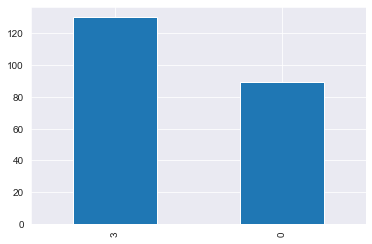

In [5]:
df.relevancy.value_counts().plot(kind='bar')

### For the next steps, it is easier to only use the information on text and relevancy

In [6]:
df = pd.read_csv('export_remigration_06_06_2020_18_57.csv', usecols = ['text','relevancy'])

In [7]:
df.head(5)

,relevancy,text
0,0,Endesgefertigter litt seit längerer Zeit an Ma...
1,0,„ „Adepesertister lt seit längerer Seit an Mag...
2,0,Endesgefertigter litt seit längerer Zeit an Ma...
3,3,Der Leiter der Zweigstelle Wien des Rückwander...
4,0,"„Ober wos denkst denn, so long ausbleibn!“\nFü..."


## Cleaning and tokenizing the text (pre-processing) <a class="anchor" id="5-bullet"></a>

Before the training fo the topic models can be started, the data has to be cleaned. The follwing functions remove punctuations, lower case the text, remove stop words and lemmatize the text. 

#### Stop words: 
The language used for the stop words can be changed. It is also possible to create own stop words or to select words that should be ignored. It helps to ignore words that are often shared in both, relevant and non-relevant articles. 

In [8]:
# Functions to clean, tokenize, and lemmatize the data
def initial_clean(text):
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower() 
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('german')#change the language here
# add your onw stop words
stop_words.extend(["Heimkehr", "Rückkehr", "heimkehren", "zurückkehren", "a", "ab","aber","ach","acht","achte","achten","achter","achtes","ag","alle","allein","allem","allen","aller","allerdings","alles","allgemeinen","als","also","am","an","andere","anderen","andern","anders","au","auch","auf","aus","ausser","außer","ausserdem","außerdem","b","bald","bei","beide","beiden","beim","beispiel","bekannt","bereits","besonders","besser","besten","bin","bis","bisher","bist","c","d","da","dabei","dadurch","dafür","dagegen","daher","dahin","dahinter","damals","damit","danach","daneben","dank","dann","daran","darauf","daraus","darf","darfst","darin","darüber","darum","darunter","das","dasein","daselbst","dass","daß","dasselbe","davon","davor","dazu","dazwischen","dein","deine","deinem","deiner","dem","dementsprechend","demgegenüber","demgemäss","demgemäß","demselben","demzufolge","den","denen","denn","denselben","der","deren","derjenige","derjenigen","dermassen","dermaßen","derselbe","derselben","des","deshalb","desselben","dessen","deswegen","d.h","dich","die","diejenige","diejenigen","dies","diese","dieselbe","dieselben","diesem","diesen","dieser","dieses","dir","doch","dort","drei","drin","dritte","dritten","dritter","drittes","du","durch","durchaus","dürfen","dürft","durfte","durften","e","eben","ebenso","ehrlich","ei","ei,","eigen","eigene","eigenen","eigener","eigenes","ein","einander","eine","einem","einen","einer","eines","einige","einigen","einiger","einiges","einmal","eins","elf","en","ende","endlich","entweder","er","Ernst","erst","erste","ersten","erster","erstes","es","etwa","etwas","euch","f","früher","fünf","fünfte","fünften","fünfter","fünftes","für","g","gab","ganz","ganze","ganzen","ganzer","ganzes","gar","gedurft","gegen","gegenüber","gehabt","gehen","geht","gekannt","gekonnt","gemacht","gemocht","gemusst","genug","gerade","gern","gesagt","geschweige","gewesen","gewollt","geworden","gibt","ging","gleich","gott","gross","groß","grosse","große","grossen","großen","grosser","großer","grosses","großes","gut","gute","guter","gutes","h","habe","haben","habt","hast","hat","hatte","hätte","hatten","hätten","heisst","her","heute","hier","hin","hinter","hoch","i","ich","ihm","ihn","ihnen","ihr","ihre","ihrem","ihren","ihrer","ihres","im","immer","in","indem","infolgedessen","ins","irgend","ist","j","ja","jahr","jahre","jahren","je","jede","jedem","jeden","jeder","jedermann","jedermanns","jedoch","jemand","jemandem","jemanden","jene","jenem","jenen","jener","jenes","jetzt","k","kam","kann","kannst","kaum","kein","keine","keinem","keinen","keiner","kleine","kleinen","kleiner","kleines","kommen","kommt","können","könnt","konnte","könnte","konnten","kurz","l","lang","lange","leicht","leide","lieber","los","m","machen","macht","machte","mag","magst","mahn","man","manche","manchem","manchen","mancher","manches","mann","mehr","mein","meine","meinem","meinen","meiner","meines","mensch","menschen","mich","mir","mit","mittel","mochte","möchte","mochten","mögen","möglich","mögt","morgen","muss","muß","müssen","musst","müsst","musste","mussten","n","na","nach","nachdem","nahm","natürlich","neben","nein","neue","neuen","neun","neunte","neunten","neunter","neuntes","nicht","nichts","nie","niemand","niemandem","niemanden","noch","nun","nur","o","ob","oben","oder","offen","oft","ohne","Ordnung","p","q","r","recht","rechte","rechten","rechter","rechtes","richtig","rund","s","sa","sache","sagt","sagte","sah","satt","schlecht","Schluss","schon","sechs","sechste","sechsten","sechster","sechstes","sehr","sei","seid","seien","sein","seine","seinem","seinen","seiner","seines","seit","seitdem","selbst","sich","sie","sieben","siebente","siebenten","siebenter","siebentes","sind","so","solang","solche","solchem","solchen","solcher","solches","soll","sollen","sollte","sollten","sondern","sonst","sowie","später","statt","t","tag","tage","tagen","tat","teil","tel","tritt","trotzdem","tun","u","über","überhaupt","übrigens","uhr","um","und","und?","uns","unser","unsere","unserer","unter","v","vergangenen","viel","viele","vielem","vielen","vielleicht","vier","vierte","vierten","vierter","viertes","vom","von","vor","w","wahr?","während","währenddem","währenddessen","wann","war","wäre","waren","wart","warum","was","wegen","weil","weit","weiter","weitere","weiteren","weiteres","welche","welchem","welchen","welcher","welches","wem","wen","wenig","wenige","weniger","weniges","wenigstens","wenn","wer","werde","werden","werdet","wessen","wie","wieder","will","willst","wir","wird","wirklich","wirst","wo","wohl","wollen","wollt","wollte","wollten","worden","wurde","würde","wurden","würden","x","y","z","z.b","zehn","zehnte","zehnten","zehnter","zehntes","zeit","zu","zuerst","zugleich","zum","zunächst","zur","zurück","zusammen","zwanzig","zwar","zwei","zweite","zweiten","zweiter","zweites","zwischen","zwölf","euer","eure","hattest","hattet","jedes","mußt","müßt","sollst","sollt","soweit","weshalb","wieso","woher","wohin"])
def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] 
    except IndexError: 
        pass
    return text

def apply_all(text):
    return stem_words(remove_stop_words(initial_clean(text)))

In [9]:

df['tokenized'] = df['text'].apply(apply_all) 


## Optional: Reducing the data to nouns, adjectives, verbs, or adverbs  <a class="anchor" id="6-bullet"></a>

This function be can used or be omitted. Sometimes, it makes sense to reduce your data to parts of speech (pos). This depents very much on the research question. To see which method works best, it makes sense to run this program once with and once without pos-tagging. The package Spacy is used for the pos tagging. Spacy can be used in many differnt languages. To use Spazy in your preferred language, you have to install the right model. This model can be found here: https://spacy.io/usage/models

In [10]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
#nlp = spacy.load('de_core_news_sm', disable=['parser', 'ner'])

#df['tokenized'] = lemmatization(df['tokenized'], allowed_postags=['NOUN', 'ADJ'])

## Having a look at the data <a class="anchor" id="7-bullet"></a>


In [12]:
df

,relevancy,text,tokenized
0,0,Endesgefertigter litt seit längerer Zeit an Ma...,"[endesgefertigt, litt, längerer, magenbeschwer..."
1,0,„ „Adepesertister lt seit längerer Seit an Mag...,"[adepesertist, lt, längerer, magenbeschwerden,..."
2,0,Endesgefertigter litt seit längerer Zeit an Ma...,"[endesgefertigt, litt, längerer, magenbeschwer..."
3,3,Der Leiter der Zweigstelle Wien des Rückwander...,"[leiter, zweigstel, wien, rückwandereramt, pg,..."
4,0,"„Ober wos denkst denn, so long ausbleibn!“\nFü...","[ober, wo, denkst, long, ausbleibn, getadelten..."
...,...,...,...
214,3,Davon sind allerdings die Rückwanderer abzuzie...,"[rückwander, abzuziehen, zahl, belief, 190809,..."
215,3,* Beweismaterial gegen die Kriegsgefangenen.\n...,"[beweismateri, kriegsgefangenen, kriegsminist,..."
216,3,Der Austausch der Kriegsgefangenen wird\nim An...,"[austausch, kriegsgefangenen, anschluß, peters..."
217,3,* Das amerikanische Echo. Aus New=York wird\nu...,"[amerikanisch, echo, newyork, geschrieben, mas..."


In [13]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
f"The number of unique words is {len(fdist)}"

'The number of unique words is 8632'

In [14]:
# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print(f"length of list: {len(doc_lengths)}")
print(f"average document length: {np.average(doc_lengths)}")
print(f"minimum document length: {min(doc_lengths)}")
print(f"maximum document length: {max(doc_lengths)}")

length of list: 219
average document length: 77.10502283105023
minimum document length: 12
maximum document length: 296


## Removing articles that are too short <a class="anchor" id="8-bullet"></a>

To optimize the topic model results, it can make sence to avoid articles with less then 30 tokens after cleaning

In [15]:
df = df[df['tokenized'].map(len) >= 30]
# make sure all tokenized items are lists
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

After cleaning and excluding short aticles, the dataframe now has: 203 articles


In [16]:
df.head()

,relevancy,text,tokenized
0,0,Endesgefertigter litt seit längerer Zeit an Ma...,"[endesgefertigt, litt, längerer, magenbeschwer..."
1,0,„ „Adepesertister lt seit längerer Seit an Mag...,"[adepesertist, lt, längerer, magenbeschwerden,..."
2,0,Endesgefertigter litt seit längerer Zeit an Ma...,"[endesgefertigt, litt, längerer, magenbeschwer..."
3,3,Der Leiter der Zweigstelle Wien des Rückwander...,"[leiter, zweigstel, wien, rückwandereramt, pg,..."
4,0,"„Ober wos denkst denn, so long ausbleibn!“\nFü...","[ober, wo, denkst, long, ausbleibn, getadelten..."


## Using the dataset to create a training and test corpus <a class="anchor" id="9-bullet"></a>

Before the method can be used on a big collection, the manual annotated dataset is being used to train the models and to find relevant and non-relevant articles. This helps to control the output and to adapt the code in order to get the best results for the collection. 

In [17]:
# create a mask of binary values
msk = np.random.rand(len(df)) < 0.599

In [18]:
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [19]:
print(len(df),len(train_df),len(test_df))

203 119 84


## Create topic models using your training corpus <a class="anchor" id="10-bullet"></a>

The function "train_lda" trains the lda model. The parameters like number of topics or chunksize can be adapted. To distinguish between relevant and non-relevant articles, a high number of topics is best suited. Of course, this can change from research question to research question, and it makes sense to train the models with a changing number of topics to find out which amount works best for the own collection.


In [20]:
def train_lda(data):
    num_topics = 250
    chunksize = 4000
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low beta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=0.2e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=50, iterations=200)
    t2 = time.time()
    print("Time to train LDA model on ", len(train_df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [21]:
dictionary,corpus,lda = train_lda(train_df)

Time to train LDA model on  119 articles:  1.8475894649823508 min


Inspecting the outcome of the topics.

In [22]:


lda.show_topic(topicid=0, topn=20)



[('tänzer', 0.0001753156),
 ('servirt', 0.0001753156),
 ('sattelt', 0.0001753156),
 ('baron', 0.0001753156),
 ('rast', 0.0001753156),
 ('pierd', 0.0001753156),
 ('schein', 0.0001753156),
 ('reitersotni', 0.0001753156),
 ('auflauern', 0.0001753156),
 ('ungezwungen', 0.0001753156),
 ('vergnügen', 0.0001753156),
 ('verkehr', 0.0001753156),
 ('weisen', 0.0001753156),
 ('werst', 0.0001753156),
 ('woloczysk', 0.0001753156),
 ('affair', 0.0001753156),
 ('allabendlich', 0.0001753156),
 ('traten', 0.0001753156),
 ('sängern', 0.0001753156),
 ('sänger', 0.0001753156)]

## Finding the dominant topic for each article <a class="anchor" id="11-bullet"></a>

This function will find the most dominant topic for each article in the training corpus. The manual annotated relevance label of each article is includet in the graph. This makes it possible to visualize relevant and non-relevant articles together with their dominant topics. This visualization helps to see how effective the models were trained. The fewer articles share the same dominant topic, the better the results: 



In [23]:
def format_topics_sentences(ldamodel=None, corpus=corpus, relevancy=df['relevancy']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add relevancy to the end of the output
    contents = pd.Series(relevancy)
    
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, relevancy=df['relevancy'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Relevancy']

# Show
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Relevancy
0,0,101.0,0.9922,"edw, herrn, voll, apothek, dr, mehrer, pearces...",0
1,1,169.0,0.9949,"dr, wohlgeboren, magenessenz, edw, herrn, appe...",0
2,2,118.0,0.9860,"lebhaft, beifal, gefangennahm, gefangenschaft,...",0
3,3,127.0,0.9983,"dö, wo, göd, ober, holt, hot, mutter, mohrenkö...",3
4,4,188.0,0.9937,"millionen, lire, schatzminist, finanziellen, w...",0


Saving the output as csv and creating lists using the numbers of the dominant topic and numbers of the relevancy level

In [24]:
df_dominant_topic.to_csv('topic_relevancy.csv')

In [25]:
import csv

In [26]:
with open('topic_relevancy.csv',  encoding="utf8") as infile:
    reader = csv.reader(infile)    
    csv_data = list(reader)


In [27]:
df_dominant_topics= pd.read_csv('topic_relevancy.csv', usecols = ['Dominant_Topic', 'Relevancy'])


In [28]:
list_topic = []
for key in csv_data: 
    list_topic.append(key[2])
topic = list_topic[1:]

list_relevancy = []
for key in csv_data:
    list_relevancy.append(key[5])
relevance = list_relevancy[1:]   

Creating a network visualization to see how well the dominant topics are separated between relevant (3) and non-relevant (0) articles. This helps to see if the topics are clearly related to the relevant articles or to the non-relevant articles. 

C:\Users\c62255\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


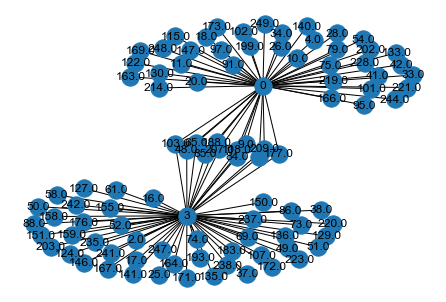

In [29]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Build a dataframe with 4 connections
df = pd.DataFrame({ 'from': relevance, 'to': topic})
df

# Build your graph
G = nx.from_pandas_edgelist(df, 'from', 'to')



# Plot it
nx.draw(G, with_labels=True)
plt.show()

To check out the results, the topics one also be inspected one by one. It might help to choose a topic connected to a relevant article (3) and compare it with a topic conntected to a non-relevant article. If the results do not make sense, restart the kurnel and train the models again. 

In [30]:
lda.show_topic(topicid=99, topn=20)

[('tänzer', 0.0001753156),
 ('servirt', 0.0001753156),
 ('sattelt', 0.0001753156),
 ('baron', 0.0001753156),
 ('rast', 0.0001753156),
 ('pierd', 0.0001753156),
 ('schein', 0.0001753156),
 ('reitersotni', 0.0001753156),
 ('auflauern', 0.0001753156),
 ('ungezwungen', 0.0001753156),
 ('vergnügen', 0.0001753156),
 ('verkehr', 0.0001753156),
 ('weisen', 0.0001753156),
 ('werst', 0.0001753156),
 ('woloczysk', 0.0001753156),
 ('affair', 0.0001753156),
 ('allabendlich', 0.0001753156),
 ('traten', 0.0001753156),
 ('sängern', 0.0001753156),
 ('sänger', 0.0001753156)]

Insepcting the shared topics and finding out what tokens are often shared between relevant and non-relevant articles (it might help to remove some of these words in order to improve the segmentation) 

In [31]:
# Inspect the shared topics
topic_share = [x for x in set(topic) if topic.count(x) > 1]
print(topic_share)

['', '166.0', '84.0', '103.0', '65.0', '209.0', '235.0', '207.0', '188.0', '177.0', '9.0', '102.0', '203.0', '136.0', '48.0', '17.0', '85.0', '159.0', '118.0']


## Finding similar articles using the Jensen Shannon function <a class="anchor" id="12-bullet"></a>

Now lets see if the articles in the test corpus are relevant or irrelevant to your research question. Therefore, we compare each unseen article in the test corpus with the topic distribution of the articles in the trained corpus. 

The first function implements a Jensen-Shannon similarity between the input query (an LDA topic distribution for a document)and the entire corpus of topic distributions. It returns an array of length M where M is the number of documents in the corpus. The second function implements the Jensen-Shannon distance above and retruns the top k (in our case 10) indices of the smallest jensen shannon distances. 

### Scipy version 1.3.1 is needed here

In [32]:
def jensen_shannon(query, matrix):
    p = query[None,:].T 
    q = matrix.T 
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

In [33]:
def get_most_similar_documents(query,matrix,k=10):
    sims = jensen_shannon(query,matrix) 
    return sims.argsort()[:k] 

Now every single article in the test corpus is being compared with the articles in the training corpus. Each useen article gets 10 most similar articles from the training corpus. If 60 percent of the automatically found similar articles were manually annotated as relevant, the new article will be marked as relevant. 



In [34]:
#create lists for your output

text_relevant = []
number_relevant = []
text_non_relevant = []
number_non_relevant = []

#find most similar articles and select between relevant and non-relevant

index = 0
while index < len(test_df) -1:
    index +=1
    new_bow = dictionary.doc2bow(test_df.iloc[index,2])
    new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])
    doc_topic_dist = np.stack([np.array([tup[1] for tup in lst]) for lst in lda[corpus]])
    doc_topic_dist.shape
    most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)
    most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
    relevant = []
    if sum(most_similar_df['relevancy']) > 17: 
        text_relevant.append(test_df.iloc[index,1])
        number_relevant.append(test_df.iloc[index,0])
    else:
        text_non_relevant.append(test_df.iloc[index,1])
        number_non_relevant.append(test_df.iloc[index,0])
    pass



In [35]:
#Create a dataframe with the automatically selected relevant and non-relevant articles

df_relevant = pd.DataFrame(np.column_stack([text_relevant, number_relevant]), 
                               columns=['Relevant_Text', 'Real_Relevancy'])

df_non_relevant = pd.DataFrame(np.column_stack([text_non_relevant, number_non_relevant]), 
                               columns=['Unrelevant_Text', 'Real_Revelancy'])


df_results = pd.concat([df_relevant,df_non_relevant], ignore_index=True, axis=1)
df_results.columns=['Relevant_Text', '3','Non_Relevant_Text', '0']
df_results.head(50)

,Relevant_Text,3,Non_Relevant_Text,0
0,In dieser Lage trat zunächst auch durch die im...,3,Nachdem Gauleiter Fritz Wächtler die Meldung d...,0
1,Ein Knirps unterm Tropenhelm\n Auf dem Anlegep...,3,"Der Stand der Sonne erinnerte Henriette daran,...",0
2,Was die materialle Versorgung der Heimkehrer\n...,3,Die „Bremen“ ist ungezählten Amerikanern\nvon ...,3
3,Die Abteikung „Reisen und Wandern“ erhielt im ...,3,Vater und dreimal schoß der Sohn. Keine Kugel ...,0
4,"Das ist alles recht schön, aber jedenfalls\nei...",3,die ebenso spannend ist wie das ihr zugrunde l...,0
5,Paganini auf. Der Kartenvorverkauf hat bereits...,3,Das Abenteuer eines unreifen Knaben wird in de...,0
6,"ausenden täglich aus Rußland zurückkehren, sin...",3,"Es ist merkwürdig, daß dieser unerwünschte Hei...",3
7,Daß die Versorgung der Heimkehrenden in der\ne...,3,"Bremen, 16. Dez. Bei der Hauptverwaltung des N...",0
8,"Das gesamte deutsche Volk, vorab wir im Gau Ti...",3,"höhnung über ihn hereinzubrechen, bei der er B...",0
9,Der Lask ist begreiflicherweise ganz besonders...,3,Repertoire des Deutschen Volkstheaters. Samsta...,0


## Calculating the score of the output <a class="anchor" id="13-bullet"></a>

The code has to be adapted until a higher score than 80 percent is reached. Topic models sometimes also need several rounds. If the score is higher than 80 percent, it can be worked with the whole dataset. It is recommended to train the models at least twice. 

In [36]:
rev_3 = []
for key in df_results['3']:
    if key == '3':
        rev_3.append(key)
rev_0 = []
for key in df_results['3']:
    if key == '0':
        rev_0.append(key)
non_rev_3 = []
for key in df_results['0']:
    if key == '3':
        non_rev_3.append(key)
non_rev_0 = []
for key in df_results['0']:
    if key == '0':
        non_rev_0.append(key)
result_right = len(non_rev_0) + len(rev_3)
result_wrng = len(non_rev_3) + len(rev_0)
all_ = len(non_rev_3) + len(rev_0) + len(non_rev_0) + len(rev_3)
score = result_right / all_
f"Your score is: {score}"




'Your score is: 0.8313253012048193'

# Using the whole collection  <a class="anchor" id="14-bullet"></a>

Importing the whole collection


In [37]:
df_all = pd.read_csv('export_remigration_all_04_06_2020_04_31.csv', usecols = ['id','language','date','newspaper_id','iiif_url','text'])

In [38]:
df_all = df_all[df_all['text'].map(type) == str]
df_all.dropna(axis=0, inplace=True, subset=['text'])
# shuffle the data
df_all = df_all.sample(frac=1.0)
df_all.reset_index(drop=True,inplace=True)
df_all.head()

,id,language,date,newspaper_id,iiif_url,text
0,neue_freie_presse_nfp19110322_article_5166,de,1911-03-22T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,"nicht unter 125,X. festarstelt gaden. Die Gele..."
1,neue_freie_presse_nfp18661011_article_70,de,1866-10-11T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,"Breslau, 9. October. (Die preußisch=ungarische..."
2,neue_freie_presse_nfp19160209_article_125,de,1916-02-09T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,Die Ankunft des Ministers Grafen Theodor\nPefa...
3,arbeiter_zeitung_aze19120516_article_36,de,1912-05-16T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,"Wien, 15. Mai.\nDas Abgeordnetenhaus setzte he..."
4,innsbrucker_nachrichten_ibn19391213_article_248,de,1939-12-13T00:00:00Z,innsbrucker_nachrichten,https://platform.newseye.eu/iiif/innsbrucker_n...,Die Rücksiedlung der Südtiroler und das Gastge...


## Cleaning (pre-process) the whole collection <a class="anchor" id="15-bullet"></a>

Repeating the same steps with the training and test corpus

In [39]:
# Functions to clean, tokenize, and lemmatize the data
def initial_clean(text):
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower() 
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('german')
# add your onw stop words
stop_words.extend(["Heimkehr", "Rückkehr", "heimkehren", "zurückkehren", "a", "ab","aber","ach","acht","achte","achten","achter","achtes","ag","alle","allein","allem","allen","aller","allerdings","alles","allgemeinen","als","also","am","an","andere","anderen","andern","anders","au","auch","auf","aus","ausser","außer","ausserdem","außerdem","b","bald","bei","beide","beiden","beim","beispiel","bekannt","bereits","besonders","besser","besten","bin","bis","bisher","bist","c","d","da","dabei","dadurch","dafür","dagegen","daher","dahin","dahinter","damals","damit","danach","daneben","dank","dann","daran","darauf","daraus","darf","darfst","darin","darüber","darum","darunter","das","dasein","daselbst","dass","daß","dasselbe","davon","davor","dazu","dazwischen","dein","deine","deinem","deiner","dem","dementsprechend","demgegenüber","demgemäss","demgemäß","demselben","demzufolge","den","denen","denn","denselben","der","deren","derjenige","derjenigen","dermassen","dermaßen","derselbe","derselben","des","deshalb","desselben","dessen","deswegen","d.h","dich","die","diejenige","diejenigen","dies","diese","dieselbe","dieselben","diesem","diesen","dieser","dieses","dir","doch","dort","drei","drin","dritte","dritten","dritter","drittes","du","durch","durchaus","dürfen","dürft","durfte","durften","e","eben","ebenso","ehrlich","ei","ei,","eigen","eigene","eigenen","eigener","eigenes","ein","einander","eine","einem","einen","einer","eines","einige","einigen","einiger","einiges","einmal","eins","elf","en","ende","endlich","entweder","er","Ernst","erst","erste","ersten","erster","erstes","es","etwa","etwas","euch","f","früher","fünf","fünfte","fünften","fünfter","fünftes","für","g","gab","ganz","ganze","ganzen","ganzer","ganzes","gar","gedurft","gegen","gegenüber","gehabt","gehen","geht","gekannt","gekonnt","gemacht","gemocht","gemusst","genug","gerade","gern","gesagt","geschweige","gewesen","gewollt","geworden","gibt","ging","gleich","gott","gross","groß","grosse","große","grossen","großen","grosser","großer","grosses","großes","gut","gute","guter","gutes","h","habe","haben","habt","hast","hat","hatte","hätte","hatten","hätten","heisst","her","heute","hier","hin","hinter","hoch","i","ich","ihm","ihn","ihnen","ihr","ihre","ihrem","ihren","ihrer","ihres","im","immer","in","indem","infolgedessen","ins","irgend","ist","j","ja","jahr","jahre","jahren","je","jede","jedem","jeden","jeder","jedermann","jedermanns","jedoch","jemand","jemandem","jemanden","jene","jenem","jenen","jener","jenes","jetzt","k","kam","kann","kannst","kaum","kein","keine","keinem","keinen","keiner","kleine","kleinen","kleiner","kleines","kommen","kommt","können","könnt","konnte","könnte","konnten","kurz","l","lang","lange","leicht","leide","lieber","los","m","machen","macht","machte","mag","magst","mahn","man","manche","manchem","manchen","mancher","manches","mann","mehr","mein","meine","meinem","meinen","meiner","meines","mensch","menschen","mich","mir","mit","mittel","mochte","möchte","mochten","mögen","möglich","mögt","morgen","muss","muß","müssen","musst","müsst","musste","mussten","n","na","nach","nachdem","nahm","natürlich","neben","nein","neue","neuen","neun","neunte","neunten","neunter","neuntes","nicht","nichts","nie","niemand","niemandem","niemanden","noch","nun","nur","o","ob","oben","oder","offen","oft","ohne","Ordnung","p","q","r","recht","rechte","rechten","rechter","rechtes","richtig","rund","s","sa","sache","sagt","sagte","sah","satt","schlecht","Schluss","schon","sechs","sechste","sechsten","sechster","sechstes","sehr","sei","seid","seien","sein","seine","seinem","seinen","seiner","seines","seit","seitdem","selbst","sich","sie","sieben","siebente","siebenten","siebenter","siebentes","sind","so","solang","solche","solchem","solchen","solcher","solches","soll","sollen","sollte","sollten","sondern","sonst","sowie","später","statt","t","tag","tage","tagen","tat","teil","tel","tritt","trotzdem","tun","u","über","überhaupt","übrigens","uhr","um","und","und?","uns","unser","unsere","unserer","unter","v","vergangenen","viel","viele","vielem","vielen","vielleicht","vier","vierte","vierten","vierter","viertes","vom","von","vor","w","wahr?","während","währenddem","währenddessen","wann","war","wäre","waren","wart","warum","was","wegen","weil","weit","weiter","weitere","weiteren","weiteres","welche","welchem","welchen","welcher","welches","wem","wen","wenig","wenige","weniger","weniges","wenigstens","wenn","wer","werde","werden","werdet","wessen","wie","wieder","will","willst","wir","wird","wirklich","wirst","wo","wohl","wollen","wollt","wollte","wollten","worden","wurde","würde","wurden","würden","x","y","z","z.b","zehn","zehnte","zehnten","zehnter","zehntes","zeit","zu","zuerst","zugleich","zum","zunächst","zur","zurück","zusammen","zwanzig","zwar","zwei","zweite","zweiten","zweiter","zweites","zwischen","zwölf","euer","eure","hattest","hattet","jedes","mußt","müßt","sollst","sollt","soweit","weshalb","wieso","woher","wohin"])
def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: 
        pass
    return text

def apply_all(text):
    return stem_words(remove_stop_words(initial_clean(text)))

In [40]:

df_all['tokenized'] = df_all['text'].apply(apply_all) 


## Optional: Reducing the data to nouns, adjectives, verbs, or adverbs <a class="anchor" id="16-bullet"></a> 

This function can used or be omitted. Sometimes, it makes sense to reduce your data to parts of speech (pos). This depents very much on the research question. To see which method works best, it makes sense to run this program once with and once without pos-tagging. We use Spacy for the pos tagging. Spacy can be used in many differnt language. To use Spazy in your preferred language, you have to install the right model. This model can be found here: https://spacy.io/usage/models

In [41]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [42]:
#nlp = spacy.load('de_core_news_sm', disable=['parser', 'ner'])

#df_all['tokenized'] = lemmatization(df_all['tokenized'], allowed_postags=['NOUN'])



### Having a look at the data


In [43]:
df_all.head(5)

,id,language,date,newspaper_id,iiif_url,text,tokenized
0,neue_freie_presse_nfp19110322_article_5166,de,1911-03-22T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,"nicht unter 125,X. festarstelt gaden. Die Gele...","[125x, festarstelt, gaden, gelelschaften, bere..."
1,neue_freie_presse_nfp18661011_article_70,de,1866-10-11T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,"Breslau, 9. October. (Die preußisch=ungarische...","[breslau, octob, preußischungarisch, legion, s..."
2,neue_freie_presse_nfp19160209_article_125,de,1916-02-09T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,Die Ankunft des Ministers Grafen Theodor\nPefa...,"[ankunft, minist, grafen, theodor, pefacsevich..."
3,arbeiter_zeitung_aze19120516_article_36,de,1912-05-16T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,"Wien, 15. Mai.\nDas Abgeordnetenhaus setzte he...","[wien, 15, mai, abgeordnetenhau, setzt, debatt..."
4,innsbrucker_nachrichten_ibn19391213_article_248,de,1939-12-13T00:00:00Z,innsbrucker_nachrichten,https://platform.newseye.eu/iiif/innsbrucker_n...,Die Rücksiedlung der Südtiroler und das Gastge...,"[rücksiedlung, südtirol, gastgewerb, gastgewer..."


In [44]:
# first get a list of all words
all_words = [word for item in list(df_all['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
f"The number of unique words is {len(fdist)}"

'The number of unique words is 23529'

In [45]:
#document length
df_all['doc_len'] = df_all['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df_all['doc_len'])
df_all.drop(labels='doc_len', axis=1, inplace=True)


print(f"length of list: {len(doc_lengths)}")
print(f"average document length: {np.average(doc_lengths)}")
print(f"minimum document length: {min(doc_lengths)}")
print(f"maximum document length: {max(doc_lengths)}")

length of list: 1154
average document length: 57.42894280762565
minimum document length: 1
maximum document length: 446


### Removing articles that are too short 


In [46]:
df_all = df_all[df_all['tokenized'].map(len) >= 30]
df_all = df_all[df_all['tokenized'].map(type) == list]
df_all.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df_all), "articles")

After cleaning and excluding short aticles, the dataframe now has: 738 articles


In [47]:
df_all.head()

,id,language,date,newspaper_id,iiif_url,text,tokenized
0,neue_freie_presse_nfp18661011_article_70,de,1866-10-11T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,"Breslau, 9. October. (Die preußisch=ungarische...","[breslau, octob, preußischungarisch, legion, s..."
1,arbeiter_zeitung_aze19120516_article_36,de,1912-05-16T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,"Wien, 15. Mai.\nDas Abgeordnetenhaus setzte he...","[wien, 15, mai, abgeordnetenhau, setzt, debatt..."
2,illustrierte_kronen_zeitung_krz19210324_articl...,de,1921-03-24T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,Wienerwaldschuhe eingetroffen sind. Da auch al...,"[wienerwaldschuh, eingetroffen, de, sorten, st..."
3,arbeiter_zeitung_aze19331019_article_310,de,1933-10-19T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,Interessant ist die Stellungnahme des\nKongres...,"[interess, stellungnahm, kongress, frage, gewe..."
4,neue_freie_presse_nfp18710203_article_773,de,1871-02-03T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,"Inzwischen ist es Zeit geworden, im Schlosse v...","[inzwischen, schloss, margenc, aufwartung, säc..."


## Calculating similarities in comparing articles to your training corpus   <a class="anchor" id="17-bullet"></a>

In [48]:
def jensen_shannon(query, matrix):
    p = query[None,:].T 
    q = matrix.T 
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

In [49]:
def get_most_similar_documents(query,matrix,k=10):
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [50]:
#create lists for your output
text_relevant = []
number_relevant = []
date_relevant = []
text_non_relevant = []
number_non_relevant = []
language_relevant = []
newspaper_id_relevant = []
iiif_url_relevant = []
id_relevant = []

#find most similar articles and select between relevant and non-relevant

index = 0
while index < len(df_all) -1:
    index +=1
    new_bow = dictionary.doc2bow(df_all.iloc[index,6])
    new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])
    doc_topic_dist = np.stack([np.array([tup[1] for tup in lst]) for lst in lda[corpus]])
    doc_topic_dist.shape
    most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)
    most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
    # Calculate 
    if sum(most_similar_df['relevancy']) > 17: 
        text_relevant.append(df_all.iloc[index,5])
        date_relevant.append(df_all.iloc[index,2])
        language_relevant.append(df_all.iloc[index,1])
        newspaper_id_relevant.append(df_all.iloc[index,3])
        iiif_url_relevant.append(df_all.iloc[index,4])
        id_relevant.append(df_all.iloc[index,0])
        
    else:
        text_non_relevant.append(df_all.iloc[index,5])
    pass


C:\Users\c62255\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


In [51]:
#transform your lists into a dataframe
df_relevant = pd.DataFrame(np.column_stack([text_relevant]), 
                               columns=['Relevant_Text'])

df_non_relevant = pd.DataFrame(np.column_stack([text_non_relevant]), 
                               columns=['Unrelevant_Text'])


df_results = pd.concat([df_relevant,df_non_relevant], ignore_index=True, axis=1)
df_results.columns=['Relevant_Text','Non_Relevant_Text']
df_results.head(5)

,Relevant_Text,Non_Relevant_Text
0,"Wien, 15. Mai.\nDas Abgeordnetenhaus setzte he...",Wienerwaldschuhe eingetroffen sind. Da auch al...
1,"Ausland.\nWien, 17. März. (Zur Tagesgeschichte...",Interessant ist die Stellungnahme des\nKongres...
2,Am stärksten ist die Rückwanderung bei den Pol...,"Inzwischen ist es Zeit geworden, im Schlosse v..."
3,Nachforschung nach den Eltern eines Kriegsgefa...,[Vortragsabend Stella Berger=Hohenfels.] Frau ...
4,"von Kriessgesengenen Pe#######emer#den, Anstau...","Agram, 20. April. [Orig.=Corr.] (Banus. Landta..."


## Exporting the results to check if the method worked well <a class="anchor" id="18-bullet"></a>

In [52]:
df_results.to_csv('results.csv')

### Saving the results in the form of your original file <a class="anchor" id="19-bullet"></a>


In [53]:
df_final = pd.DataFrame(np.column_stack([id_relevant, language_relevant, newspaper_id_relevant, date_relevant, iiif_url_relevant, text_relevant]), 
                               columns=['id', 'language', 'date', 'newspaper_id', 'iiif_url', 'text'])


df_new = pd.concat([df_final], ignore_index=True, axis=1)
df_new.columns=['id','language', 'date', 'newspaper_id', 'iiif_url', 'text']
df_new.head(5)

,id,language,date,newspaper_id,iiif_url,text
0,arbeiter_zeitung_aze19120516_article_36,de,arbeiter_zeitung,1912-05-16T00:00:00Z,https://platform.newseye.eu/iiif/arbeiter_zeit...,"Wien, 15. Mai.\nDas Abgeordnetenhaus setzte he..."
1,neue_freie_presse_nfp19130318_article_473,de,neue_freie_presse,1913-03-18T00:00:00Z,https://platform.newseye.eu/iiif/neue_freie_pr...,"Ausland.\nWien, 17. März. (Zur Tagesgeschichte..."
2,neue_freie_presse_nfp19220519_article_677,de,neue_freie_presse,1922-05-19T00:00:00Z,https://platform.newseye.eu/iiif/neue_freie_pr...,Am stärksten ist die Rückwanderung bei den Pol...
3,innsbrucker_nachrichten_ibn19210215_article_84,de,innsbrucker_nachrichten,1921-02-15T00:00:00Z,https://platform.newseye.eu/iiif/innsbrucker_n...,Nachforschung nach den Eltern eines Kriegsgefa...
4,illustrierte_kronen_zeitung_krz19180607_articl...,de,illustrierte_kronen_zeitung,1918-06-07T00:00:00Z,https://platform.newseye.eu/iiif/illustrierte_...,"von Kriessgesengenen Pe#######emer#den, Anstau..."


## Exporting the final collection  <a class="anchor" id="29-bullet"></a>

In [54]:
df_new.to_csv('Collection_no_false_positives.csv')